1.1 Aliasing when a sampling a picture

In [26]:
import numpy as np
from PIL import Image

# Open the image from the specified path
img = Image.open('/Users/tom/Desktop/IMG_5115.png')

# Get and print image dimensions
width, height = img.size
print(f'Width: {width}, Height: {height}')

# Convert the image into a numpy array for manual manipulation
picture_array = np.array(img)

# --- METHOD 1: Downsampling via Slicing ---
# This takes every 2nd pixel (crude downsampling, prone to aliasing)
downsampled_slicing = Image.fromarray(picture_array[::8, ::8])

# --- METHOD 2: Downsampling via Resize ---
# This uses built-in interpolation (usually includes an anti-aliasing filter)
downsampled_resized = img.resize((width // 8, height // 8))

# Display the results
downsampled_slicing.show()
downsampled_resized.show()

# --- SAVE THE IMAGES ---
# Saving the raw sliced image (watch out for aliasing here!)
downsampled_slicing.save('/Users/tom/Desktop/downsampled_slicing.png')

# Saving the resized image (this should look smoother)
downsampled_resized.save('/Users/tom/Desktop/downsampled_resized.png')

Width: 5184, Height: 3456


For a sampling frequency of 4 one can already see differences withouth zooming in, though when zooming in one can notice differences no matter how small the smapling frequency is.

Using the resize method, the picture appears smoother and from afar it looks better than the subsampled one though upon closer inspection one cannot actually identify mote details. 

In [28]:
import soundfile as sf

data, samplerate = sf.read('/Users/tom/Downloads/00252_4.9dB/00252_4.9dB_PCM16.wav')

# Print the sampling format and the duration of the audio signal
print(f'Sampling format: {data.dtype}')
print(f'Sample rate: {samplerate}, Länge: {len(data)/samplerate} Sekunden')

# Change sample rate to 24,000 Hz
data_24000Hz = data[::2]
sf.write('/Users/tom/Downloads/00252_4.9dB/00252_4.9dB_24000Hz.wav', data_24000Hz, 24000)

# Change sample rate to 16,000 Hz
data_16000Hz = data[::3]
sf.write('/Users/tom/Downloads/00252_4.9dB/00252_4.9dB_16000Hz.wav', data_16000Hz, 16000)

# Change sample rate to 8,000 Hz
data_8000Hz = data[::6]
sf.write('/Users/tom/Downloads/00252_4.9dB/00252_4.9dB_8000Hz.wav', data_8000Hz, 8000)

Sampling format: float64
Sample rate: 48000, Länge: 14.397166666666667 Sekunden


In [29]:
import scipy.signal as signal
import soundfile as sf

# Load original 48 kHz audio
data, samplerate = sf.read('/Users/tom/Downloads/00252_4.9dB/00252_4.9dB_PCM16.wav')

# Downsampling from 48 kHz to 16 kHz requires a factor of 3
downsampling_factor = 3

# Define normalized cutoff frequency (1 / factor)
# This corresponds to 8 kHz, the Nyquist limit for the target 16 kHz rate
wn_cut = 1 / downsampling_factor

# Design a 10th-order Butterworth low-pass filter to prevent aliasing
b, a = signal.butter(10, wn_cut, 'low', analog=False, output='ba')

# Apply the filter to the original signal
data_filtered = signal.lfilter(b, a, data)

# Save the filtered signal by taking every 3rd sample
sf.write('/Users/tom/Downloads/00252_4.9dB/00252_4.9dB_filtered_16000Hz.wav', data_filtered[::3], 16000)

### Quantization and Bit Depth

A 16-bit integer can represent $2^{16}$ values, ranging from $0$ to $(65536 - 1) = 65535$. The quantization step size is:

$$\Delta = \frac{A_{\max} - A_{\min}}{2^N}$$

We therefore examine the actual amplitude range and divide it by the number of quantization levels. With a larger word length (or bit depth) $N$, the number of quantization steps $Q$ also increases:

$$Q = 2^N$$

In [6]:
def reduce_bitdepth(signal, target_bitdepth):
    original_bitdepth = 16  # assuming original is 16-bit
    shift_amount = original_bitdepth - target_bitdepth
    quantized_signal = np.right_shift(signal, shift_amount)
    quantized_signal = np.left_shift(quantized_signal, shift_amount)
    return quantized_signal

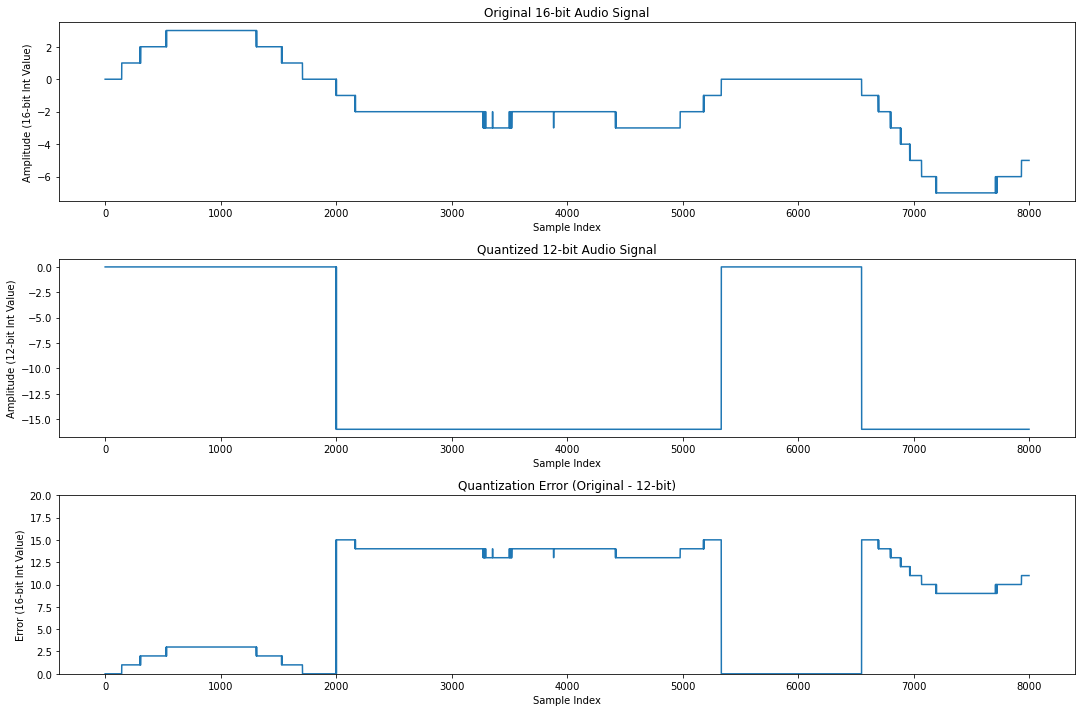

In [66]:
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np

# Load original 16-bit signal as integers to allow bit-shifting
data_16bit, samplerate = sf.read('/Users/tom/Downloads/00252_4.9dB/00252_4.9dB_PCM16_quiet.wav', dtype='int16')

# Reduce bit depth to 14-bit and 10-bit using the bit-shift function
data_14bit = reduce_bitdepth(data_16bit, 14)
data_12bit = reduce_bitdepth(data_16bit, 12)
data_10bit = reduce_bitdepth(data_16bit, 10)

# Save the 10-bit version (stored within a 16-bit WAV container)
sf.write('/Users/tom/Downloads/00252_4.9dB/00252_4.9dB_PCM14new.wav', data_14bit, samplerate)

y_min, y_max = 0, 20  # Adjust these values based on the actual amplitude range of your signal

# Plot waveforms to visualize the impact of bit depth reduction
plt.figure(figsize=(15, 10))

# Plot 16-bit (Original)
plt.subplot(3, 1, 1)
plt.title('Original 16-bit Audio Signal')
plt.plot(data_16bit[12000:20000])  # Plot a small segment for clarity
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (16-bit Int Value)')

# Plot 10-bit
plt.subplot(3, 1, 2)
plt.title('Quantized 12-bit Audio Signal')
plt.plot(data_12bit[12000:20000])  # Plot the same segment for comparison
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (12-bit Int Value)')

# Plot quantization error (difference between original and 14-bit)
plt.subplot(3, 1, 3)
plt.title('Quantization Error (Original - 12-bit)')
plt.plot(data_16bit[12000:20000] - data_12bit[12000:20000])
plt.xlabel('Sample Index')
plt.ylabel('Error (16-bit Int Value)')

plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()

To calculate the SNR, we need the total energy of the signal:


$$P_x = \sum_{n=1}^{N} x^2(n)$$


In [64]:

data_12bit_float = data_12bit.astype(np.float64)
data_16bit_float = data_16bit.astype(np.float64)

quant_err = data_16bit_float - data_12bit_float

quantized_power = np.sum(np.square(data_12bit_float))

noise_power = np.sum(np.square(quant_err))

snr = 10 * np.log10(quantized_power / noise_power)

print(f'Signal-to-Noise Ratio (SNR) for 12-bit quantization: {snr:.2f} dB')

Signal-to-Noise Ratio (SNR) for 12-bit quantization: 11.24 dB


As seen in the plot the quantized 12-bit audio signal already contains a noticeable quantization error when comparing the two signals for a smaller sample range.
However, when listening to the 12-bit audio it still sounds clean. The Signal-to-Noise-Ration for the overall signal (12-bit) is 36.80 dB

A difference in sound is clearly perceptible for a 10-bit audio signal where there is a significant quantization noise.